In [137]:
%matplotlib inline

# libraries for imbalanced learning
from imblearn.under_sampling import RandomUnderSampler,CondensedNearestNeighbour, TomekLinks
from imblearn.over_sampling import RandomOverSampler, SMOTE,KMeansSMOTE, ADASYN

import pandas as pd
import numpy as np

# sklearn modules
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score, classification_report, recall_score,precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier

import plotly.express as px
import matplotlib.pyplot as plt

from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

# Echonest audio features - IMBALANCED LEARNING
## 1. Premise
The hyper-parameters and results for unbalanced classifiers are taken  from the notebooks:
- bin-genre_decision-tree_KNN  (section 2)

Sinci in our previous analysis we found out that both Decision Tree and KNN had higher performances with PCA, we decided to improve our results starting from those classifiers.

__________________________________
# 2 Binary genre - ROCK & JAZZ
__________________________________
## a) Import dataset

In [138]:
binclass_dataset = pd.read_csv('/Users/gaetanoantonicchio/Documents/GitHub/DataMining-2/src/Module 1/Anomaly Detection/echo_audiofeatures_outlierfree.csv')
binclass_dataset.set_index('track_id', inplace=True)
#binclass_dataset.drop('listens',axis=1, inplace=True)
#binclass_dataset.drop('comments',axis=1, inplace=True)
binclass_dataset = binclass_dataset[binclass_dataset['genre_top'].isin(['Rock','Jazz'])]
binclass_dataset.head()

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,valence,tempo,duration,bit_rate,genre_top
track_id,,,,,,,,,,,
144,0.909011,0.443643,0.641997,0.924092,0.267669,0.089659,0.788251,128.537,82,256,Jazz
145,0.235506,0.438672,0.487752,0.716122,0.070359,0.047298,0.650452,120.790,326,256,Jazz
146,0.532019,0.417681,0.476422,0.402500,0.172105,0.035361,0.682397,135.468,354,256,Jazz
147,0.778410,0.706681,0.866116,0.806703,0.104650,0.065083,0.917613,120.218,232,256,Jazz
153,0.988306,0.255661,0.979774,0.973006,0.121342,0.051740,0.034018,90.241,405,256,Rock


[]

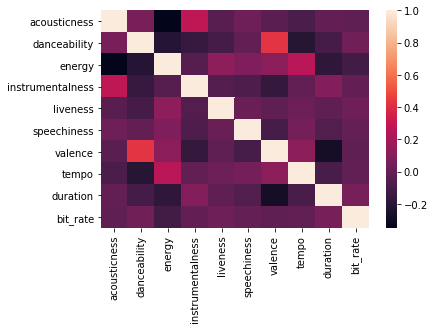

In [139]:
corr = binclass_dataset.corr()
sns.heatmap(corr)
plt.plot()

The highest correlation is the one between valence and danceability ***approximately 0.5***

In [140]:
print('Class distribution before balancing')
pd.concat(
    [binclass_dataset.genre_top.value_counts(),
                round(binclass_dataset.genre_top.value_counts(normalize=True).mul(100),2)],
                axis=1,
                keys=('counts','percentage (%)')
)

Class distribution before balancing


,counts,percentage (%)
Rock,3665,94.73
Jazz,204,5.27


In [141]:
# Data preprocessing
le = preprocessing.LabelEncoder()
binclass_dataset['genre_top'] = le.fit_transform(binclass_dataset['genre_top'])
print('Legend:\n0: Jazz\n1: Rock')
# Define the labels
labels = binclass_dataset[['genre_top']]
labels.reset_index(drop=True, inplace=True)
labels = labels[['genre_top']]

Legend:
0: Jazz
1: Rock


In [142]:
# remove labels from dataset
binclass_dataset.drop('genre_top', axis=1, inplace=True)

In [143]:
labels.head()

,genre_top
0,0
1,0
2,0
3,0
4,1


In [144]:
# normalize the dataset
scaler = StandardScaler()
scaled_features = scaler.fit_transform(binclass_dataset)

## b) Compute PCA and plot distribution in 2D

In [145]:
# compute PCA using optimal number of components: 8 ( discovered in the notebook mentioned above)
pca = PCA(8,random_state=42)
pca.fit(scaled_features)
X_pca = pca.transform(scaled_features)

In [146]:
# split data in development and internal test
X, X_test, y, y_test = train_test_split(X_pca, labels, test_size=0.30, random_state=42, stratify=labels)

In [147]:
# development set shape
X.shape, y.shape

((2708, 8), (2708, 1))

In [148]:
# internal test shape
X_test.shape, y_test.shape

((1161, 8), (1161, 1))

In [149]:
print('Class distribution before balancing after splitting in train test')
pd.concat(
    [y.value_counts(),
                round(y.value_counts(normalize=True).mul(100),2)],
                axis=1,
                keys=('counts','percentage (%)')
)

Class distribution before balancing after splitting in train test


,counts,percentage (%)
genre_top,,
1,2565,94.72
0,143,5.28


In [150]:
# function for plotting data in 2D with PCA
def pca_2D(data, y, graph_title):
    """
    This function plots in 2D the features of X.
    :param X: array of features
    :param y: labels
    :param graph_title: title to be displayed on the graph
    :return: 2D scatter-plot
    """
    # dataframe for plotting PCA
    df = pd.DataFrame()
    df['pca1'] = data[:,0]
    df['pca2'] = data[:,1]
    df['genres'] = le.inverse_transform(y)
    # plot scatter of PCA
    plt.figure(figsize=(10,7))
    sns.scatterplot(
        x="pca1", y="pca2",
        hue='genres',
        palette={'Jazz':'darkblue','Rock':'coral'},
        data=df,
        legend="full",
        alpha=0.8
    )
    plt.title(graph_title, fontsize= 15)
    plt.show()

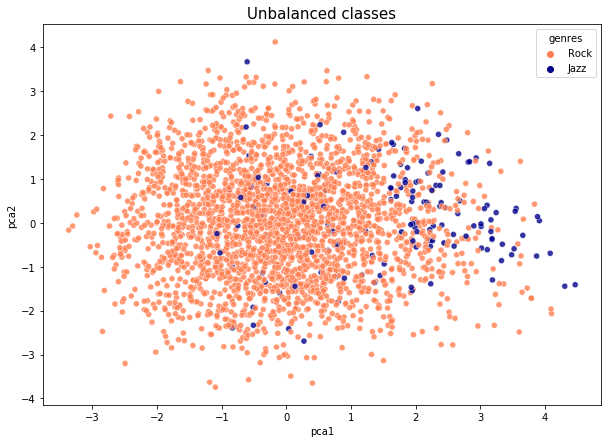

In [151]:
pca_2D(X, y,'Unbalanced classes')

## c) Imbalanced learning:
#### c.1) Undersampling - Random

In [152]:
under_sample = RandomUnderSampler(random_state=42)
# Store under-sampled data
X_under, y_under = under_sample.fit_resample(X,y)

In [153]:
print('Legend:\n0: Jazz\n1: Rock\nClass distribution after Random Undersampling:')
y_under.value_counts()

Legend:
0: Jazz
1: Rock
Class distribution after Random Undersampling:


genre_top
0            143
1            143
dtype: int64

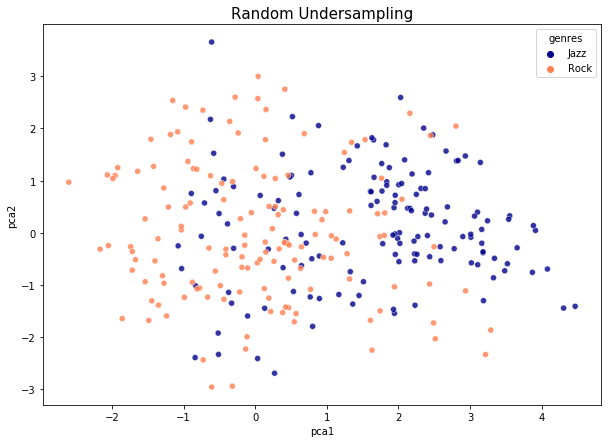

In [154]:
pca_2D(X_under,y_under,'Random Undersampling')

#### c.2) Condensed Nearest Neighbor (CNN)

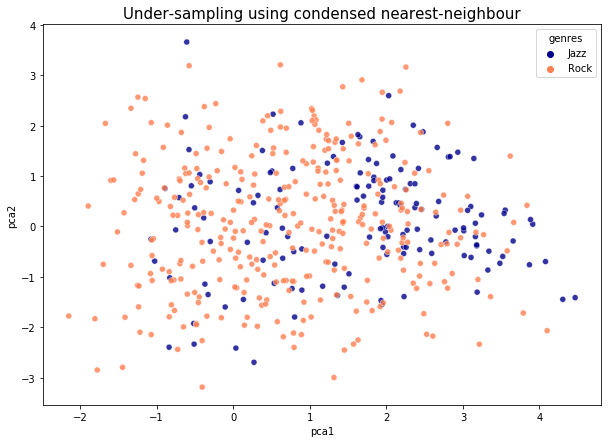

In [155]:
# Apply Condensed Nearest Neighbours
cnn = CondensedNearestNeighbour()
X_cnn, y_cnn = cnn.fit_resample(X, y)
#X_res_vis = pca.transform(X_resampled)
pca_2D(X_cnn,y_cnn,'Under-sampling using condensed nearest-neighbour')

#### c.3) Tomek's Link

In [156]:
help(TomekLinks)

Help on class TomekLinks in module imblearn.under_sampling._prototype_selection._tomek_links:

class TomekLinks(imblearn.under_sampling.base.BaseCleaningSampler)
 |  TomekLinks(*, sampling_strategy='auto', n_jobs=None)
 |  
 |  Under-sampling by removing Tomek's links.
 |  
 |  Read more in the :ref:`User Guide <tomek_links>`.
 |  
 |  Parameters
 |  ----------
 |  sampling_strategy : str, list or callable
 |      Sampling information to sample the data set.
 |  
 |      - When ``str``, specify the class targeted by the resampling. Note the
 |        the number of samples will not be equal in each. Possible choices
 |        are:
 |  
 |          ``'majority'``: resample only the majority class;
 |  
 |          ``'not minority'``: resample all classes but the minority class;
 |  
 |          ``'not majority'``: resample all classes but the majority class;
 |  
 |          ``'all'``: resample all classes;
 |  
 |          ``'auto'``: equivalent to ``'not minority'``.
 |  
 |      - Whe

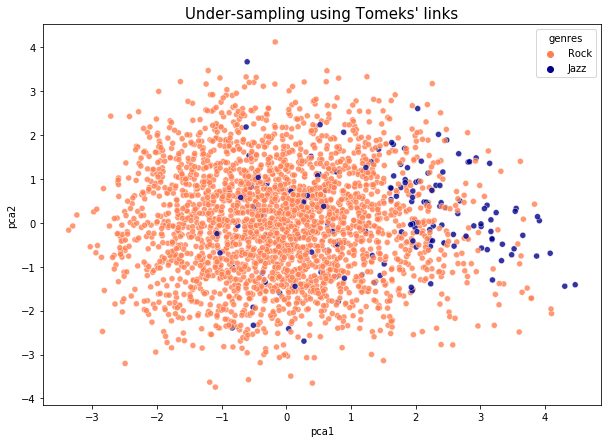

In [157]:
tomeks = TomekLinks(sampling_strategy ='majority')
X_tomek, y_tomek = tomeks.fit_resample(X, y)

pca_2D(X_tomek, y_tomek, 'Under-sampling using Tomeks\' links')

In [158]:
y_tomek.value_counts()

genre_top
1            2539
0             143
dtype: int64

#### c.4) Oversampling - Random

In [159]:
over_sample = RandomOverSampler(sampling_strategy='minority')
X_over, y_over = over_sample.fit_resample(X, y)

In [160]:
X_over.shape, y_over.shape

((5130, 8), (5130, 1))

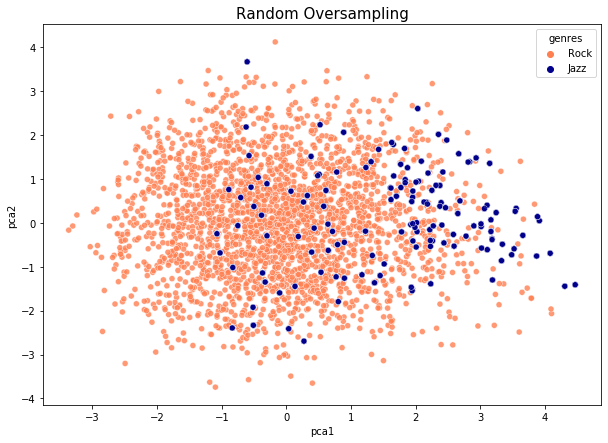

In [161]:
pca_2D(X_over, y_over, 'Random Oversampling')

#### c.5) SMOTE

In [162]:
smote_over = SMOTE()
X_smote, y_smote = smote_over.fit_resample(X, y)
X_smote.shape, y_smote.shape

((5130, 8), (5130, 1))

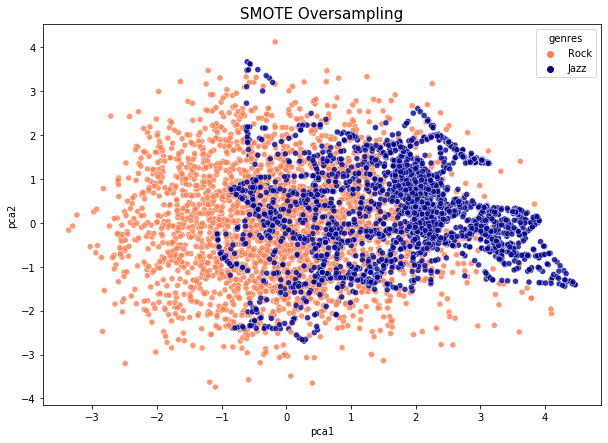

In [163]:
pca_2D(X_smote, y_smote, 'SMOTE Oversampling')

#### K-Means SMOTE

In [164]:
ksmote = KMeansSMOTE(random_state=42, sampling_strategy='not majority',kmeans_estimator=90, k_neighbors=5,cluster_balance_threshold=0)
X_ksmote, y_ksmote = ksmote.fit_resample(X, y)

In [165]:
y_ksmote.value_counts()

genre_top
0            2570
1            2565
dtype: int64

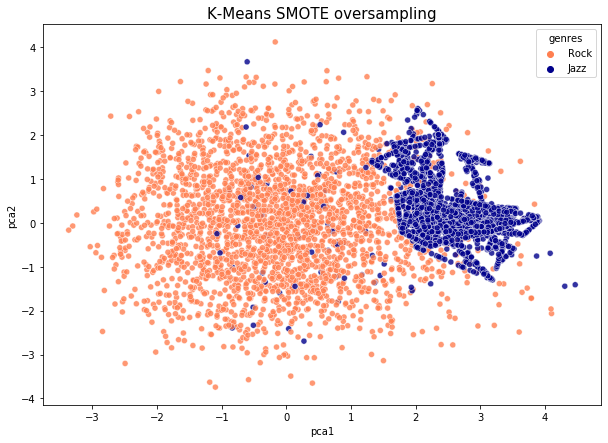

In [166]:
pca_2D(X_ksmote, y_ksmote, "K-Means SMOTE oversampling")

#### c.6) ADASYN

In [167]:
adasyn = ADASYN()
X_adasyn, y_adasyn = adasyn.fit_resample(X, y)

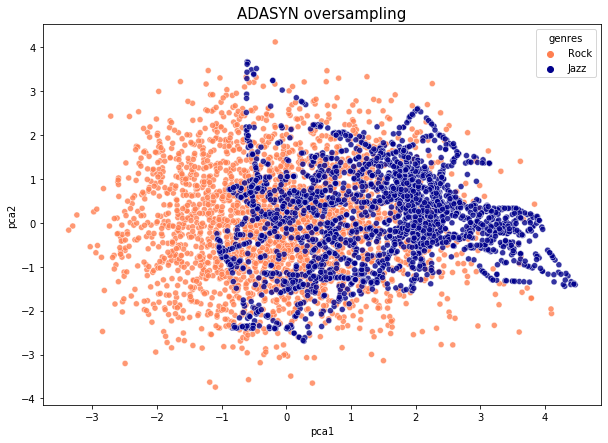

In [168]:
pca_2D(X_adasyn, y_adasyn, "ADASYN oversampling")

## d) Decision tree

### Random Search 

In [169]:
from sklearn.model_selection import RandomizedSearchCV

In [170]:
data =[(X_under,y_under),(X_cnn,y_cnn),(X_tomek, y_tomek),(X_over,y_over),
       (X_smote,y_smote),(X_ksmote,y_ksmote),(X_adasyn,y_adasyn)]

titles =['undersampling','condensed NN','Tomek links',
         'oversampling','SMOTE','K-means SMOTE','ADASYN' ]
params = {"criterion":["gini", "entropy"],
         "max_depth":[x for x in range(4,10)],
         "min_samples_split": [x for x in range(4,50)],
         "min_samples_leaf": [x for x in range(10,55)]}

for model, title in zip(data,titles):
    dt = DecisionTreeClassifier()
    clf = RandomizedSearchCV(estimator=dt, param_distributions=params, cv=5, n_iter=500, random_state=42,
                             verbose=True, return_train_score=True, )
    search = clf.fit(model[0], model[1])
    print(f"*******{title}*******")
    print(search.best_params_)
    print(f"accuracy validation: {search.best_score_}")

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2500 out of 2500 | elapsed:   11.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


*******undersampling*******
{'min_samples_split': 20, 'min_samples_leaf': 14, 'max_depth': 5, 'criterion': 'gini'}
accuracy validation: 0.7343012704174228
Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=1)]: Done 2500 out of 2500 | elapsed:   13.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


*******condensed NN*******
{'min_samples_split': 47, 'min_samples_leaf': 12, 'max_depth': 6, 'criterion': 'gini'}
accuracy validation: 0.7242162844519251
Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=1)]: Done 2500 out of 2500 | elapsed:   38.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


*******Tomek links*******
{'min_samples_split': 43, 'min_samples_leaf': 15, 'max_depth': 4, 'criterion': 'entropy'}
accuracy validation: 0.947802190166486
Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=1)]: Done 2500 out of 2500 | elapsed:   46.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


*******oversampling*******
{'min_samples_split': 13, 'min_samples_leaf': 11, 'max_depth': 9, 'criterion': 'entropy'}
accuracy validation: 0.9231968810916179
Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=1)]: Done 2500 out of 2500 | elapsed:  1.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


*******SMOTE*******
{'min_samples_split': 26, 'min_samples_leaf': 10, 'max_depth': 9, 'criterion': 'gini'}
accuracy validation: 0.8686159844054581
Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=1)]: Done 2500 out of 2500 | elapsed:  1.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


*******K-means SMOTE*******
{'min_samples_split': 28, 'min_samples_leaf': 13, 'max_depth': 5, 'criterion': 'gini'}
accuracy validation: 0.9402142161635834
Fitting 5 folds for each of 500 candidates, totalling 2500 fits
*******ADASYN*******
{'min_samples_split': 34, 'min_samples_leaf': 11, 'max_depth': 9, 'criterion': 'entropy'}
accuracy validation: 0.7990224828934507


[Parallel(n_jobs=1)]: Done 2500 out of 2500 | elapsed:  1.1min finished


### d.2) Retrain Models : Unbalanced vs Balanced

In [171]:
data_training =[(X,y),(X_under,y_under),(X_cnn,y_cnn),(X_tomek, y_tomek),(X_over,y_over),
       (X_smote,y_smote),(X_ksmote,y_ksmote),(X_adasyn,y_adasyn)]

titles =['unbalanced','undersampling','condensed NN','Tomek links',
         'oversampling','SMOTE','K-means SMOTE','ADASYN' ]

models ={
    
    'unbalanced':DecisionTreeClassifier(criterion= 'gini',max_depth=5,
                                        min_samples_leaf= 20, min_samples_split=10),
   
    "undesampling":DecisionTreeClassifier(criterion= 'entropy',max_depth=9,
                                        min_samples_leaf= 38, min_samples_split=25),
    
    "condensed NN":DecisionTreeClassifier(criterion= 'gini',max_depth=5,
                                        min_samples_leaf= 20, min_samples_split=10),
    
    "Tomek links":DecisionTreeClassifier(criterion= 'gini',max_depth=5,
                                        min_samples_leaf= 20, min_samples_split=10),
    
    "oversampling":DecisionTreeClassifier(criterion= 'entropy',max_depth=9,
                                        min_samples_leaf= 11, min_samples_split=13),
    
    "SMOTE":DecisionTreeClassifier(criterion= 'gini',max_depth=9,
                                        min_samples_leaf= 10, min_samples_split=26),
    
    "k-means SMOTE":DecisionTreeClassifier(criterion= 'gini',max_depth=7,
                                        min_samples_leaf= 11, min_samples_split=6),
    
    "ADASYN":DecisionTreeClassifier(criterion= 'entropy',max_depth=9,
                                        min_samples_leaf= 20, min_samples_split=36)
}

roc_curves ={} #stores roc curves for each model
fpr_tpr = [] #stores false positive and true positive rates for each models
f1_scores_minc =[] # stores f1 score of minority class for each model
precision_minc=[]
recall_minc=[]

for model,data,title in zip(models, data_training, titles):
    dt = models[model]
    dt.fit(data[0],data[1])
    y_pred = dt.predict(X_test)

    # computes roc curve for each classifier
    y_score = dt.predict_proba(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
    roc_auc = auc(fpr, tpr)

    # saves the roc curve of each classifier in the dictionary roc_curves
    roc_curves[title] = roc_auc
    # saves the fpr and tpr of each classifier in a list of tuples "fpr_tpr"
    fpr_tpr.append((fpr,tpr))
    
    # save f1 score of minority class 
    f1_scores_minc.append(f1_score(y_test, y_pred, average=None)[0])
    # save recall score of minority class
    recall_minc.append(recall_score(y_test, y_pred, average=None)[0])
    # save precision score of minority class
    precision_minc.append(precision_score(y_test, y_pred, average=None)[0])
    
    print(f"*** {title} classification ***")
    print('Accuracy %s' % accuracy_score(y_test, y_pred))
    print('F1-score %s\n' % f1_score(y_test, y_pred, average=None))
    print('Recall %s' % recall_score(y_test, y_pred, average=None))
    print('Precision %s' % precision_score(y_test, y_pred,average=None))
    print(classification_report(y_test, y_pred))

*** unbalanced classification ***
Accuracy 0.9500430663221361
F1-score [0.275      0.97413024]

Recall [0.18032787 0.99272727]
Precision [0.57894737 0.95621716]
              precision    recall  f1-score   support

           0       0.58      0.18      0.28        61
           1       0.96      0.99      0.97      1100

    accuracy                           0.95      1161
   macro avg       0.77      0.59      0.62      1161
weighted avg       0.94      0.95      0.94      1161

*** undersampling classification ***
Accuracy 0.7329888027562446
F1-score [0.24019608 0.83803553]

Recall [0.80327869 0.72909091]
Precision [0.14121037 0.98525799]
              precision    recall  f1-score   support

           0       0.14      0.80      0.24        61
           1       0.99      0.73      0.84      1100

    accuracy                           0.73      1161
   macro avg       0.56      0.77      0.54      1161
weighted avg       0.94      0.73      0.81      1161

*** condensed NN clas

In [172]:
# classification with cost matrix
dt_w = DecisionTreeClassifier(criterion= 'gini',max_depth=5, min_samples_leaf= 20, min_samples_split=10, class_weight='balanced')
dt_w.fit(X, y)
y_pred_w = dt_w.predict(X_test)

# save f1, precision, recall scores of minority class
f1_scores_minc.append(f1_score(y_test, y_pred_w, average=None)[0])
recall_minc.append(recall_score(y_test, y_pred, average=None)[0])
precision_minc.append(precision_score(y_test, y_pred, average=None)[0])

print(f"*** cost-matrix classification ***")
print('Accuracy %s' % accuracy_score(y_test, y_pred_w))
print('F1-score %s\n' % f1_score(y_test, y_pred_w, average=None))
print(classification_report(y_test, y_pred_w))


*** cost-matrix classification ***
Accuracy 0.85099052540913
F1-score [0.30522088 0.91654607]

              precision    recall  f1-score   support

           0       0.20      0.62      0.31        61
           1       0.98      0.86      0.92      1100

    accuracy                           0.85      1161
   macro avg       0.59      0.74      0.61      1161
weighted avg       0.94      0.85      0.88      1161



Text(0.5, 0, '')

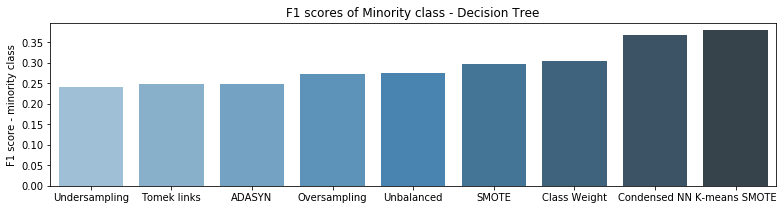

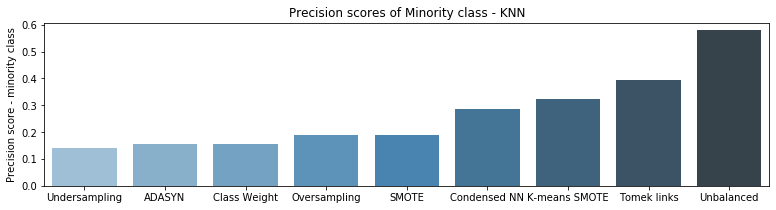

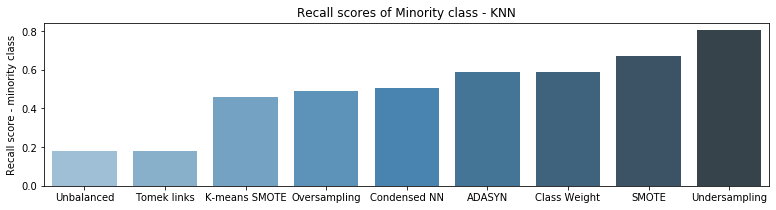

In [173]:
# plot F1 scores for minority class
df = pd.DataFrame()
df['f1'] = f1_scores_minc
df['precision'] = precision_minc
df['recall'] = recall_minc
df['models'] = ['Unbalanced','Undersampling','Condensed NN','Tomek links','Oversampling','SMOTE','K-means SMOTE',
                'ADASYN', 'Class Weight']


plt.figure(figsize=(13,3))
sns.barplot(x="models", y="f1", data=df.sort_values(by='f1'), palette="Blues_d")
plt.ylabel('F1 score - minority class')
plt.title('F1 scores of Minority class - Decision Tree')
plt.xlabel(None)

plt.figure(figsize=(13,3))
sns.barplot(x="models", y="precision", data=df.sort_values(by='precision'), palette="Blues_d")
plt.ylabel('Precision score - minority class')
plt.title('Precision scores of Minority class - KNN')
plt.xlabel(None)

plt.figure(figsize=(13,3))
sns.barplot(x="models", y="recall", data=df.sort_values(by='recall'), palette="Blues_d")
plt.ylabel('Recall score - minority class')
plt.title('Recall scores of Minority class - KNN')
plt.xlabel(None)

### d.3) Compare results

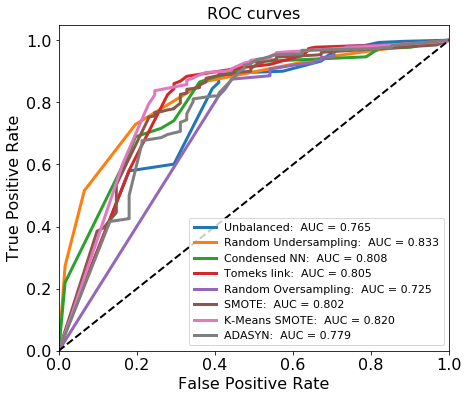

In [174]:
# plot roc curves
plt.figure(figsize=(7,6))

plt.plot(fpr_tpr[0][0], fpr_tpr[0][1], lw=3, label='Unbalanced:  AUC = %.3f' % roc_curves['unbalanced'])
plt.plot(fpr_tpr[1][0], fpr_tpr[1][1], lw=3, label='Random Undersampling:  AUC = %.3f' % roc_curves['undersampling'])
plt.plot(fpr_tpr[2][0], fpr_tpr[2][1], lw=3, label='Condensed NN:  AUC = %.3f' % roc_curves['condensed NN'])
plt.plot(fpr_tpr[3][0], fpr_tpr[3][1], lw=3, label='Tomeks link:  AUC = %.3f' % roc_curves['Tomek links'])
plt.plot(fpr_tpr[4][0], fpr_tpr[4][1], lw=3, label='Random Oversampling:  AUC = %.3f' % roc_curves['oversampling'])
plt.plot(fpr_tpr[5][0], fpr_tpr[5][1], lw=3, label='SMOTE:  AUC = %.3f' % roc_curves['SMOTE'])
plt.plot(fpr_tpr[6][0], fpr_tpr[6][1], lw=3, label='K-Means SMOTE:  AUC = %.3f' % roc_curves['K-means SMOTE'])
plt.plot(fpr_tpr[7][0], fpr_tpr[7][1], lw=3, label='ADASYN:  AUC = %.3f' % roc_curves['ADASYN'])


plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curves', fontsize=16)
plt.legend(loc="lower right", fontsize=11, frameon=True)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

## d) KNN

### Random Search 

In [175]:
data =[(X_under,y_under),(X_cnn,y_cnn),(X_tomek, y_tomek),(X_over,y_over),
       (X_smote,y_smote),(X_ksmote,y_ksmote),(X_adasyn,y_adasyn)]

titles =['undersampling','condensed NN','Tomek links',
         'oversampling','SMOTE','K-means SMOTE','ADASYN' ]

params = {"weights":["distance", "uniform"],
         "n_neighbors":[x for x in range(3,25)],
         "metric": ["euclidean", "manhattan", "minkowski", "chebyshev"],
         }

for model, title in zip(data,titles):
    knn = KNeighborsClassifier()
    clf = RandomizedSearchCV(estimator=knn, param_distributions=params, cv=5, n_iter=200, random_state=42,
                             verbose=True, return_train_score=True, )
    search = clf.fit(model[0], model[1])
    print(f"*******{title}*******")
    print(search.best_params_)
    print(f"accuracy validation: {search.best_score_}")

Fitting 5 folds for each of 176 candidates, totalling 880 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 880 out of 880 | elapsed:   11.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


*******undersampling*******
{'weights': 'distance', 'n_neighbors': 23, 'metric': 'chebyshev'}
accuracy validation: 0.7621294615849971
Fitting 5 folds for each of 176 candidates, totalling 880 fits


[Parallel(n_jobs=1)]: Done 880 out of 880 | elapsed:   15.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


*******condensed NN*******
{'weights': 'distance', 'n_neighbors': 21, 'metric': 'manhattan'}
accuracy validation: 0.7345466021460131
Fitting 5 folds for each of 176 candidates, totalling 880 fits


[Parallel(n_jobs=1)]: Done 880 out of 880 | elapsed:  1.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


*******Tomek links*******
{'weights': 'distance', 'n_neighbors': 5, 'metric': 'manhattan'}
accuracy validation: 0.9552607076350095
Fitting 5 folds for each of 176 candidates, totalling 880 fits


[Parallel(n_jobs=1)]: Done 880 out of 880 | elapsed:  3.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


*******oversampling*******
{'weights': 'distance', 'n_neighbors': 3, 'metric': 'manhattan'}
accuracy validation: 0.967056530214425
Fitting 5 folds for each of 176 candidates, totalling 880 fits


[Parallel(n_jobs=1)]: Done 880 out of 880 | elapsed:  3.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


*******SMOTE*******
{'weights': 'distance', 'n_neighbors': 4, 'metric': 'euclidean'}
accuracy validation: 0.9458089668615985
Fitting 5 folds for each of 176 candidates, totalling 880 fits


[Parallel(n_jobs=1)]: Done 880 out of 880 | elapsed:  4.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


*******K-means SMOTE*******
{'weights': 'distance', 'n_neighbors': 4, 'metric': 'manhattan'}
accuracy validation: 0.9626095423563777
Fitting 5 folds for each of 176 candidates, totalling 880 fits
*******ADASYN*******
{'weights': 'distance', 'n_neighbors': 4, 'metric': 'manhattan'}
accuracy validation: 0.9245356793743891


[Parallel(n_jobs=1)]: Done 880 out of 880 | elapsed:  4.7min finished


### Retrain Models: Unbalanced vs Balanced

In [180]:

models ={
    
    'unbalanced':KNeighborsClassifier(n_neighbors = 8, weights='distance', metric='euclidean'),
   
    "undesampling":KNeighborsClassifier(n_neighbors = 23, weights='distance', metric='chebyshev'),
    
    "condensed NN":KNeighborsClassifier(n_neighbors = 21, weights='distance', metric='manhattan'),
    
    "Tomek links":KNeighborsClassifier(n_neighbors = 5, weights='distance', metric='manhattan'),
    
    "oversampling":KNeighborsClassifier(n_neighbors = 3, weights='distance', metric='manhattan'),
    
    "SMOTE":KNeighborsClassifier(n_neighbors = 4, weights='distance', metric='euclidean'),
    
    "k-means SMOTE":KNeighborsClassifier(n_neighbors = 4, weights='distance', metric='manhattan'),
    
    "ADASYN":KNeighborsClassifier(n_neighbors = 4, weights='distance', metric='manhattan')
    
}

roc_curves_knn ={}
fpr_tpr_knn = []
f1_scores_minc = []
recall_minc = []
precision_minc =[]

for model, data, title in zip(models, data_training, titles):
    knn = models[model]
    knn.fit(data[0],data[1])
    y_pred = knn.predict(X_test)

    # computes roc curve for each classifier
    y_score = knn.predict_proba(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
    roc_auc_knn = auc(fpr, tpr)

    # saves the roc curve of each classifier in the dictionary roc_curves
    roc_curves_knn[title] = roc_auc_knn
    # saves the fpr and tpr of each classifier in a list of tuples "fpr_tpr"
    fpr_tpr_knn.append((fpr,tpr))
    # save f1 score of minority class 
    f1_scores_minc.append(f1_score(y_test, y_pred, average=None)[0])   
    # save recall score of minority class
    recall_minc.append(recall_score(y_test, y_pred, average=None)[0])
    # save precision score of minority class
    precision_minc.append(precision_score(y_test, y_pred, average=None)[0])
    
    print(f"*** {title} classification ***")
    print('Accuracy %s' % accuracy_score(y_test, y_pred))
    print('F1-score %s\n' % f1_score(y_test, y_pred, average=None))
    print(classification_report(y_test, y_pred))

*** undersampling classification ***
Accuracy 0.9465977605512489
F1-score [0.27906977 0.97227191]

              precision    recall  f1-score   support

           0       0.48      0.20      0.28        61
           1       0.96      0.99      0.97      1100

    accuracy                           0.95      1161
   macro avg       0.72      0.59      0.63      1161
weighted avg       0.93      0.95      0.94      1161

*** condensed NN classification ***
Accuracy 0.7786391042204995
F1-score [0.24188791 0.87039839]

              precision    recall  f1-score   support

           0       0.15      0.67      0.24        61
           1       0.98      0.78      0.87      1100

    accuracy                           0.78      1161
   macro avg       0.56      0.73      0.56      1161
weighted avg       0.93      0.78      0.84      1161

*** Tomek links classification ***
Accuracy 0.9474590869939707
F1-score [0.41904762 0.97248534]

              precision    recall  f1-score   suppor

The condensed NearestNeighbor is the balancing technique yeilding the best results.<br>
The f1 score for class 0 goes from 0.24 to 0.38. This is due to the fact that **recall** improved as well, going from
0.15 in the unbalanced case (the classifier was not able to detect class 0) to 0.32 with the CNN. <br>
The precision decreses of few percent points (from 0.58 to 0.46) which is still acceptable considering the high recall.<br>
In terms of **recall**, **ADASYN** and **Random Undersampling** yeilded the highest recall (0.71 and 0.72 respectively). However after this rebalancing, although the f1 score increased to approximately 0.30, the precision of the model for that class resulted to be very low (0.19 for both). This means that in order to predict class 0 the classifier started to assign label 0 to more samples including those for which the real target was class 1.

In [179]:
# plot F1 scores for minority class
df = pd.DataFrame()
df['f1'] = f1_scores_minc
df['precision'] = precision_minc
df['recall'] = recall_minc
df['models'] = ['Unbalanced','Undersampling','Condensed NN','Tomek links','Oversampling','SMOTE','K-means SMOTE',
                'ADASYN']


plt.figure(figsize=(13,3))
sns.barplot(x="models", y="f1", data=df.sort_values(by='f1'), palette="Blues_d")
plt.ylabel('F1 score - minority class')
plt.title('F1 scores of Minority class - KNN')
plt.xlabel(None)

plt.figure(figsize=(13,3))
sns.barplot(x="models", y="precision", data=df.sort_values(by='precision'), palette="Blues_d")
plt.ylabel('Precision score - minority class')
plt.title('Precision scores of Minority class - KNN')
plt.xlabel(None)

plt.figure(figsize=(13,3))
sns.barplot(x="models", y="recall", data=df.sort_values(by='recall'), palette="Blues_d")
plt.ylabel('Recall score - minority class')
plt.title('Recall scores of Minority class - KNN')
plt.xlabel(None)

ValueError: Length of values (8) does not match length of index (7)

In [ ]:
# plot roc curves
plt.figure(figsize=(7,6))

plt.plot(fpr_tpr_knn[0][0], fpr_tpr_knn[0][1], lw=2, label='Unbalanced:  AUC = %.3f' % roc_curves_knn['unbalanced'])
plt.plot(fpr_tpr_knn[1][0], fpr_tpr_knn[1][1], lw=2, label='Random Undersampling:  AUC = %.3f' % roc_curves_knn['undersampling'])
plt.plot(fpr_tpr_knn[2][0], fpr_tpr_knn[2][1], lw=2, label='Condensed NN:  AUC = %.3f' % roc_curves_knn['condensed NN'])
plt.plot(fpr_tpr_knn[3][0], fpr_tpr_knn[3][1], lw=2, label='Tomeks link:  AUC = %.3f' % roc_curves_knn['Tomek links'])
plt.plot(fpr_tpr_knn[4][0], fpr_tpr_knn[4][1], lw=2, label='Random Oversampling:  AUC = %.3f' % roc_curves_knn['oversampling'])
plt.plot(fpr_tpr_knn[5][0], fpr_tpr_knn[5][1], lw=2, label='SMOTE:  AUC = %.3f' % roc_curves_knn['SMOTE'])
plt.plot(fpr_tpr[6][0], fpr_tpr[6][1], lw=3, label='K-Means SMOTE:  AUC = %.3f' % roc_curves['K-means SMOTE'])
plt.plot(fpr_tpr[7][0], fpr_tpr[7][1], lw=3, label='ADASYN:  AUC = %.3f' % roc_curves['ADASYN'])



plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curves', fontsize=16)
plt.legend(loc="lower right", fontsize=11, frameon=True)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()